# 1.3 Data Augmentation and Feature Engineering (30/100 points)
Improve your model quality via data augmentation techniques and feature engineering. Suggestions for augmentations include time stretching/compression, time shifting, adding noise, random cropping,
resampling, amplitude scaling, and frequency domain augmentations via inverse Fourier transformations. You can use specialized libraries of your choice to extract additional features or perform data augmentation. Suggested libraries include: BioSPPy, HeartPy, WFDB and pyECG. Depending on the level of engineered features, it might be beneficial for you to change the model into an ensemble of
various techniques (e.g., random forest, SVM, and NN). All selected techniques must be implemented as a part of your ML pipeline to operate as pre- processing steps on the entire dataset, or on individual mini-batch elements during training. Expected Results: Code for applying the data augmentation techniques and a summary of their impact on model quality. For full points, the report must include justifications for the selected augmentation techniques and their placement in your ML pipeline (on batches or the entire dataset). Use the model trained on augmented data to produce the augment.csv predictions of the test dataset.

<b>Expected Results:</b> Code for applying the data augmentation techniques and a summary of their impact on model quality. For full points, the report must include justifications for the selected augmentation techniques and their placement in your ML pipeline (on batches or the entire dataset). Use the model trained on augmented data to produce the augment.csv predictions of the test dataset.

## Step 1: Initial Setup

In [1]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fft import fft, ifft
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

# Biomedical signal processing
try:
    import wfdb
    import wfdb.processing
    WFDB_AVAILABLE = True
    print("✅ WFDB library imported successfully!")
except ImportError:
    WFDB_AVAILABLE = False
    print("⚠️ WFDB library not available. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wfdb"])
    import wfdb
    import wfdb.processing
    WFDB_AVAILABLE = True
    print("✅ WFDB library installed and imported successfully!")

# Deep learning
import tensorflow as tf

# Utilities
import joblib
import utils
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

✅ WFDB library imported successfully!


/Users/burakpolat/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


✅ All libraries imported successfully!
TensorFlow version: 2.19.0
NumPy version: 2.0.2


## Step 2: Load the Pre-processed Data

In [2]:
# Load the preprocessed data from the previous notebook
print("Loading preprocessed data...")

try:
    X_train_split, y_train_split = joblib.load("../processed/train_split.pkl")
    X_val_split, y_val_split = joblib.load("../processed/val_split.pkl")
    metadata = joblib.load("../processed/dataset_metadata.pkl")
    
    print(f"✅ Data loaded successfully!")
    print(f"Training samples: {len(X_train_split)}")
    print(f"Validation samples: {len(X_val_split)}")
    print(f"Classes: {metadata['class_names']}")
    
except FileNotFoundError:
    print("❌ Preprocessed data not found. Please run the dataset exploration notebook first.")
    raise

Loading preprocessed data...
✅ Data loaded successfully!
Training samples: 4943
Validation samples: 1236
Classes: {0: 'Normal', 1: 'AF', 2: 'Other', 3: 'Noisy'}


## Step 3: Define Data Augmentation Functions

Here, the functions for each augmentation technique is defined. These functions will be combined into a pipeline to create augmented training samples. The chosen techniques are:
1.  **Adding Gaussian Noise**: To improve robustness against noisy signals.
2.  **Time Shifting**: To make the model invariant to the exact start time of the ECG pattern.
3.  **Amplitude Scaling**: To handle variations in measurement sensitivity.
4.  **Time Stretching/Compressing**: To simulate different heart rates.
5.  **Frequency Domain Masking**: To improve robustness to frequency-specific noise and variations.

In [3]:
def add_noise(signal, noise_level=0.05):
    """Adds Gaussian noise to the signal."""
    noise = np.random.normal(0, noise_level, len(signal))
    return signal + noise

def shift_signal(signal, max_shift_pct=0.15):
    """Shifts the signal left or right by a random amount."""
    max_shift = int(len(signal) * max_shift_pct)
    shift = np.random.randint(-max_shift, max_shift)
    return np.roll(signal, shift)

def scale_amplitude(signal, min_scale=0.9, max_scale=1.1):
    """Scales the amplitude of the signal by a random factor."""
    scale = np.random.uniform(min_scale, max_scale)
    return signal * scale

def stretch_signal(signal, stretch_factor_range=(0.8, 1.2), fs=300):
    """Stretches or compresses the signal in time using WFDB for robust resampling."""
    if not WFDB_AVAILABLE:
        # Fallback to scipy if wfdb is not installed
        stretch_factor = np.random.uniform(*stretch_factor_range)
        new_len = int(len(signal) * stretch_factor)
        return scipy.signal.resample(signal, new_len)

    stretch_factor = np.random.uniform(*stretch_factor_range)
    target_fs = int(fs * stretch_factor)
    
    # resample_sig returns the resampled signal and annotations
    resampled_sig, _ = wfdb.processing.resample_sig(signal, fs, target_fs)
    
    return resampled_sig

def frequency_mask(signal, mask_fraction=0.15, fs=300):
    """
    Applies a frequency mask to the signal.
    This involves transforming the signal to the frequency domain,
    masking a random portion of it, and transforming it back.
    """
    f_signal = fft(signal)
    n_samples = len(f_signal)
    
    # Don't mask the DC component (f=0)
    mask_start = np.random.randint(1, int(n_samples / 2 * (1 - mask_fraction)))
    mask_end = int(mask_start + n_samples / 2 * mask_fraction)
    
    # Create a mask for positive and negative frequencies
    mask = np.ones(n_samples, dtype=bool)
    mask[mask_start:mask_end] = False
    mask[-mask_end:-mask_start] = False  # Apply symmetric mask
    
    f_signal_masked = f_signal * mask
    
    # Return the real part of the inverse transform
    return np.real(ifft(f_signal_masked))

## Step 4: Create the Augmentation Pipeline

This pipeline will apply a random selection of the augmentation techniques to an input signal. This approach introduces more variability than applying the same set of augmentations to every signal.

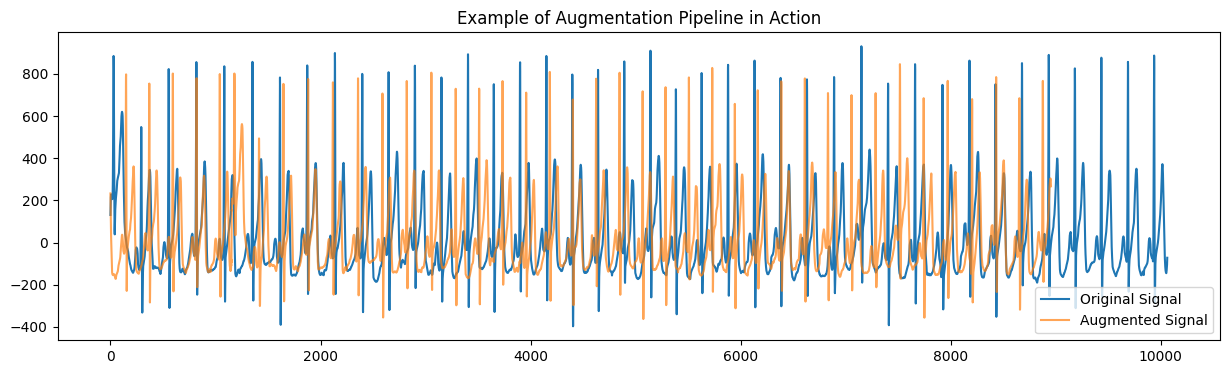

In [5]:
def augment_signal(signal, augmentations, p=0.5):
    """Applies a random subset of augmentations to the signal."""
    augmented_signal = signal.copy()
    
    for aug in augmentations:
        if np.random.rand() < p:
            augmented_signal = aug(augmented_signal)
            
    return augmented_signal

# List of augmentation functions to use in the pipeline
augmentation_pipeline = [
    add_noise,
    shift_signal,
    scale_amplitude,
    stretch_signal,
    frequency_mask,
]

# Example of the pipeline in action
original_signal = X_train_split[0]
augmented_example = augment_signal(original_signal, augmentation_pipeline)

plt.figure(figsize=(15, 4))
plt.plot(original_signal, label='Original Signal')
plt.plot(augmented_example, label='Augmented Signal', alpha=0.7)
plt.title("Example of Augmentation Pipeline in Action")
plt.legend()
plt.show()

## Step 5: Apply Augmentations to the Training Dataset

Now an augmented dataset will be created. To maintain a balance and not overwhelm the original data, we will create one augmented version for each original training sample. This doubles the size of our training set.

In [6]:
print("Applying augmentations to the training set...")

X_train_augmented = list(X_train_split)
y_train_augmented = list(y_train_split)

for i in tqdm(range(len(X_train_split)), desc="Augmenting Data"):
    original_signal = X_train_split[i]
    augmented_signal = augment_signal(original_signal, augmentation_pipeline)
    
    X_train_augmented.append(augmented_signal)
    y_train_augmented.append(y_train_split[i])

# Convert back to numpy arrays
X_train_augmented = np.array(X_train_augmented, dtype=object)
y_train_augmented = pd.Series(y_train_augmented)

print(f"Original training set size: {len(X_train_split)}")
print(f"Augmented training set size: {len(X_train_augmented)}")

Applying augmentations to the training set...


Augmenting Data: 100%|██████████| 4943/4943 [00:01<00:00, 3389.00it/s]

Original training set size: 4943
Augmented training set size: 9886


## Step 6: Feature Engineering (Optional)

While the deep learning models can learn features directly from the raw signal, we can also explore adding engineered features. For this exercise, we will focus on the augmentations, but this section demonstrates how you could extract features using libraries like `wfdb`. These features could be used with models like Random Forest or SVMs.

In [6]:
def extract_features(signal, fs=300):
    """Extracts a simple set of features from an ECG signal."""
    
    # Use wfdb to find R-peaks
    try:
        qrs_inds = wfdb.processing.gqrs_detect(sig=signal, fs=fs)
        
        # Heart Rate Variability (HRV) features
        if len(qrs_inds) > 1:
            rr_intervals = np.diff(qrs_inds) / fs
            hr = 60 / rr_intervals
            
            hr_mean = np.mean(hr)
            hr_std = np.std(hr)
            rmssd = np.sqrt(np.mean(np.diff(rr_intervals)**2))
        else:
            hr_mean, hr_std, rmssd = 0, 0, 0
            
    except Exception as e:
        # Fallback if R-peak detection fails
        hr_mean, hr_std, rmssd = 0, 0, 0

    # Basic statistical features
    mean = np.mean(signal)
    std = np.std(signal)
    skewness = stats.skew(signal)
    kurt = stats.kurtosis(signal)
    
    return [mean, std, skewness, kurt, hr_mean, hr_std, rmssd]

# Example of feature extraction
# We won't use this for the main model training, but it's here for demonstration
if WFDB_AVAILABLE:
    features = extract_features(X_train_split[0])
    feature_names = ['Mean', 'Std Dev', 'Skewness', 'Kurtosis', 'HR Mean', 'HR Std', 'RMSSD']
    print("Example Extracted Features:")
    for name, val in zip(feature_names, features):
        print(f"  {name}: {val:.4f}")
else:
    print("Skipping feature extraction example as WFDB is not available.")

Example Extracted Features:
  Mean: 15.0629
  Std Dev: 188.2846
  Skewness: 1.7450
  Kurtosis: 3.7159
  HR Mean: 0.0000
  HR Std: 0.0000
  RMSSD: 0.0000


## Step 7: Model Training with Augmented Data

Now we'll train both the baseline STFT-CNN-RNN model and the ResNet model using our augmented dataset.

In [7]:
# Import our model architectures and training utilities
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# Import our custom model architectures
sys.path.insert(0, '../models')
from baseline_model import (
    create_baseline_model, 
    get_baseline_training_config, 
    compile_baseline_model,
    STFTLayer,
    ReshapeForRNN
)
from resnet_model import (
    create_resnet_model,
    get_resnet_training_config,
    compile_resnet_model
)
from training_utils import (
    preprocess_data,
    train_model,
    evaluate_model,
    generate_test_predictions
)

baseline_config = get_baseline_training_config()
resnet_config = get_resnet_training_config()
print("baseline_config:", baseline_config)
print("resnet_config:", resnet_config)

print("✅ Model architectures and utilities imported successfully!")

baseline_config: {'initial_lr': 1e-05, 'optimizer': <keras.src.optimizers.adam.Adam object at 0x17ff87f70>, 'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'callbacks': [<keras.src.callbacks.early_stopping.EarlyStopping object at 0x17ff87d90>, <keras.src.callbacks.model_checkpoint.ModelCheckpoint object at 0x17ff87f10>, <keras.src.callbacks.reduce_lr_on_plateau.ReduceLROnPlateau object at 0x3000171f0>, <baseline_model.LearningRateTracker object at 0x17ff227f0>], 'lr_tracker': <baseline_model.LearningRateTracker object at 0x17ff227f0>, 'custom_objects': {'STFTLayer': <class 'baseline_model.STFTLayer'>, 'ReshapeForRNN': <class 'baseline_model.ReshapeForRNN'>}}
resnet_config: {'initial_lr': 0.001, 'optimizer': <keras.src.optimizers.adam.Adam object at 0x10a03b5b0>, 'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'callbacks': [<keras.src.callbacks.early_stopping.EarlyStopping object at 0x10a03bdf0>, <keras.src.callbacks.model_checkpoint.ModelCheckpoint object at 0

In [8]:
# Preprocess the augmented data for training
print("🔄 Preprocessing augmented data for model training...")

# Use the training utilities to preprocess data
X_train_final, X_val_final, y_train_final, y_val_final, input_shape = preprocess_data(
    X_train_augmented, 
    X_val_split, 
    y_train_augmented, 
    y_val_split, 
    max_len=8000, 
    n_classes=len(metadata['class_names'])
)

print(f"✅ Data preprocessing complete!")
print(f"   Training data shape: {X_train_final.shape}")
print(f"   Validation data shape: {X_val_final.shape}")
print(f"   Input shape for models: {input_shape}")
print(f"   Number of classes: {len(metadata['class_names'])}")

# Training parameters
EPOCHS = 50
BATCH_SIZE = 16
print(f"\n🎯 Training parameters:")
print(f"   Epochs: {EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")

🔄 Preprocessing augmented data for model training...
Preprocessing ECG data...
Number of training samples: 9886
Number of validation samples: 1236
------------------------------
Shape of X_train after padding and reshape: (9886, 8000, 1)
Shape of X_val after padding and reshape: (1236, 8000, 1)
------------------------------
Shape of y_train_encoded: (9886, 4)
Shape of y_val_encoded: (1236, 4)

Sample of original labels: [0 2 0 0 2]
Sample of one-hot encoded labels:
 [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]

Input shape for models: (8000, 1)
✅ Data preprocessing complete!
   Training data shape: (9886, 8000, 1)
   Validation data shape: (1236, 8000, 1)
   Input shape for models: (8000, 1)
   Number of classes: 4

🎯 Training parameters:
   Epochs: 50
   Batch size: 16


### Training the Baseline STFT-CNN-RNN Model with Augmented Data

🏗️ Creating baseline STFT-CNN-RNN model...

📋 Baseline Model Architecture:

📋 Baseline Model Architecture:


🏗️ Creating baseline STFT-CNN-RNN model...

📋 Baseline Model Architecture:

📋 Baseline Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stft_layer (STFTLayer)          │ (None, 61, 129, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 59, 127, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 59, 127, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 27, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_for_rnn (ReshapeForRNN) │ (None, 13, 1920)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 80)             │       640,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           324 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 659,844 (2.52 MB)

 Trainable params: 659,652 (2.52 MB)

 Non-trainable params: 192 (768.00 B)

🏗️ Creating baseline STFT-CNN-RNN model...

📋 Baseline Model Architecture:

📋 Baseline Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stft_layer (STFTLayer)          │ (None, 61, 129, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 59, 127, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 59, 127, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 27, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_for_rnn (ReshapeForRNN) │ (None, 13, 1920)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 80)             │       640,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           324 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 659,844 (2.52 MB)

 Trainable params: 659,652 (2.52 MB)

 Non-trainable params: 192 (768.00 B)


🚀 Training baseline model with augmented data...

TRAINING BASELINE STFT-CNN-RNN (AUGMENTED)
Initial learning rate: 1e-05
Starting training for the Baseline STFT-CNN-RNN (Augmented)...
Epoch 1/50
618/618 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5269 - loss: 1.0988
Epoch 1: val_loss improved from inf to 0.92720, saving model to baseline_model.keras

Epoch 1: val_loss improved from inf to 0.92720, saving model to baseline_model.keras
Epoch 1: Learning rate = 1.00e-05
618/618 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.5269 - loss: 1.0987 - val_accuracy: 0.6003 - val_loss: 0.9272 - learning_rate: 1.0000e-05
Epoch 2/50
Epoch 1: Learning rate = 1.00e-05
618/618 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.5269 - loss: 1.0987 - val_accuracy: 0.6003 - val_loss: 0.9272 - learning_rate: 1.0000e-05
Epoch 2/50
617/618 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5822 - loss: 0.9665
Epoch 2: val_loss improved from 0.92720 to 0.87899, saving model to baseline_model.keras

Epoch 

🏗️ Creating baseline STFT-CNN-RNN model...

📋 Baseline Model Architecture:

📋 Baseline Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stft_layer (STFTLayer)          │ (None, 61, 129, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 59, 127, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 59, 127, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 27, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_for_rnn (ReshapeForRNN) │ (None, 13, 1920)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 80)             │       640,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           324 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 659,844 (2.52 MB)

 Trainable params: 659,652 (2.52 MB)

 Non-trainable params: 192 (768.00 B)


🚀 Training baseline model with augmented data...

TRAINING BASELINE STFT-CNN-RNN (AUGMENTED)
Initial learning rate: 1e-05
Starting training for the Baseline STFT-CNN-RNN (Augmented)...
Epoch 1/50
618/618 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5269 - loss: 1.0988
Epoch 1: val_loss improved from inf to 0.92720, saving model to baseline_model.keras

Epoch 1: val_loss improved from inf to 0.92720, saving model to baseline_model.keras
Epoch 1: Learning rate = 1.00e-05
618/618 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.5269 - loss: 1.0987 - val_accuracy: 0.6003 - val_loss: 0.9272 - learning_rate: 1.0000e-05
Epoch 2/50
Epoch 1: Learning rate = 1.00e-05
618/618 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.5269 - loss: 1.0987 - val_accuracy: 0.6003 - val_loss: 0.9272 - learning_rate: 1.0000e-05
Epoch 2/50
617/618 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5822 - loss: 0.9665
Epoch 2: val_loss improved from 0.92720 to 0.87899, saving model to baseline_model.keras

Epoch 

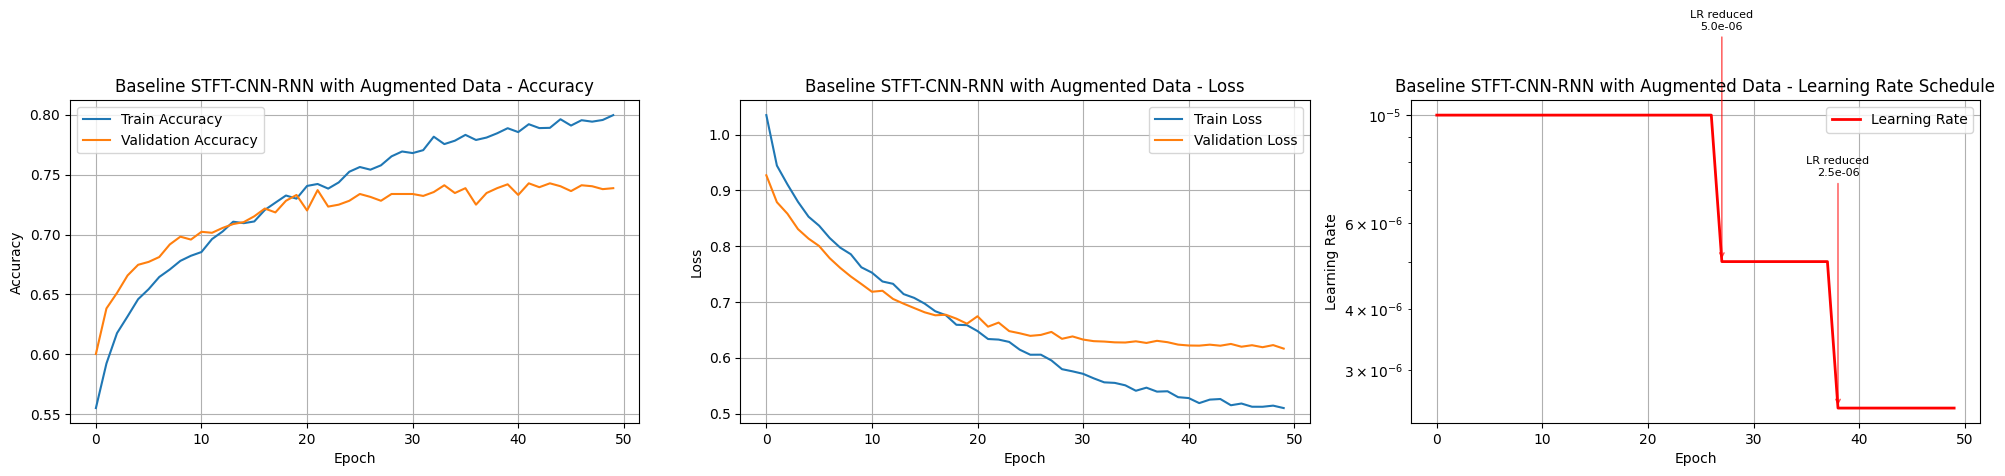

✅ Baseline model training completed!


In [9]:
# Create and compile the baseline model
print("🏗️ Creating baseline STFT-CNN-RNN model...")
baseline_model_aug = create_baseline_model(input_shape, len(metadata['class_names']))
baseline_model_aug, baseline_config = compile_baseline_model(baseline_model_aug)

# Display model architecture
print("\n📋 Baseline Model Architecture:")
baseline_model_aug.summary()

# Train the baseline model on augmented data
print(f"\n🚀 Training baseline model with augmented data...")
history_baseline_aug = train_model(
    baseline_model_aug,
    X_train_final,
    y_train_final,
    X_val_final,
    y_val_final,
    baseline_config,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    model_name="Baseline STFT-CNN-RNN (Augmented)"
)

# Plot training history
utils.plot_history_with_lr(history_baseline_aug, "Baseline STFT-CNN-RNN with Augmented Data", baseline_config['lr_tracker'])

print("✅ Baseline model training completed!")

### Training the ResNet Model with Augmented Data

🏗️ Creating 1D ResNet model...

📋 ResNet Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 4000, 32)  │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 4000, 32)  │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 4000, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 2000, 32)  │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 2000, 32)  │      3,104 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 32)  │        128 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 2000, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 2000, 32)  │      3,104 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 32)  │        128 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2000, 32)  │          0 │ batch_normalizat… │
│                     │                   │            │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 2000, 32)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 2000, 32)  │      3,104 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 32)  │        128 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 2000, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 2000, 32)  │      3,104 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 32)  │        128 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 2000, 32)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 251,908 (984.02 KB)

 Trainable params: 249,668 (975.27 KB)

 Non-trainable params: 2,240 (8.75 KB)


🚀 Training ResNet model with augmented data...

TRAINING 1D RESNET (AUGMENTED)
Initial learning rate: 0.001
Starting training for the 1D ResNet (Augmented)...
Epoch 1/50
618/618 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5688 - loss: 1.0201
Epoch 1: val_loss improved from inf to 0.87160, saving model to resnet_model.keras
Epoch 1: Learning rate = 1.00e-03
618/618 ━━━━━━━━━━━━━━━━━━━━ 71s 111ms/step - accuracy: 0.5689 - loss: 1.0200 - val_accuracy: 0.6019 - val_loss: 0.8716 - learning_rate: 0.0010
Epoch 2/50
618/618 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.6116 - loss: 0.8462
Epoch 2: val_loss improved from 0.87160 to 0.71030, saving model to resnet_model.keras
618/618 ━━━━━━━━━━━━━━━━━━━━ 72s 117ms/step - accuracy: 0.6116 - loss: 0.8462 - val_accuracy: 0.6788 - val_loss: 0.7103 - learning_rate: 0.0010
Epoch 3/50
618/618 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.6564 - loss: 0.7671
Epoch 3: val_loss improved from 0.71030 to 0.70970, saving model to resnet_model.ker

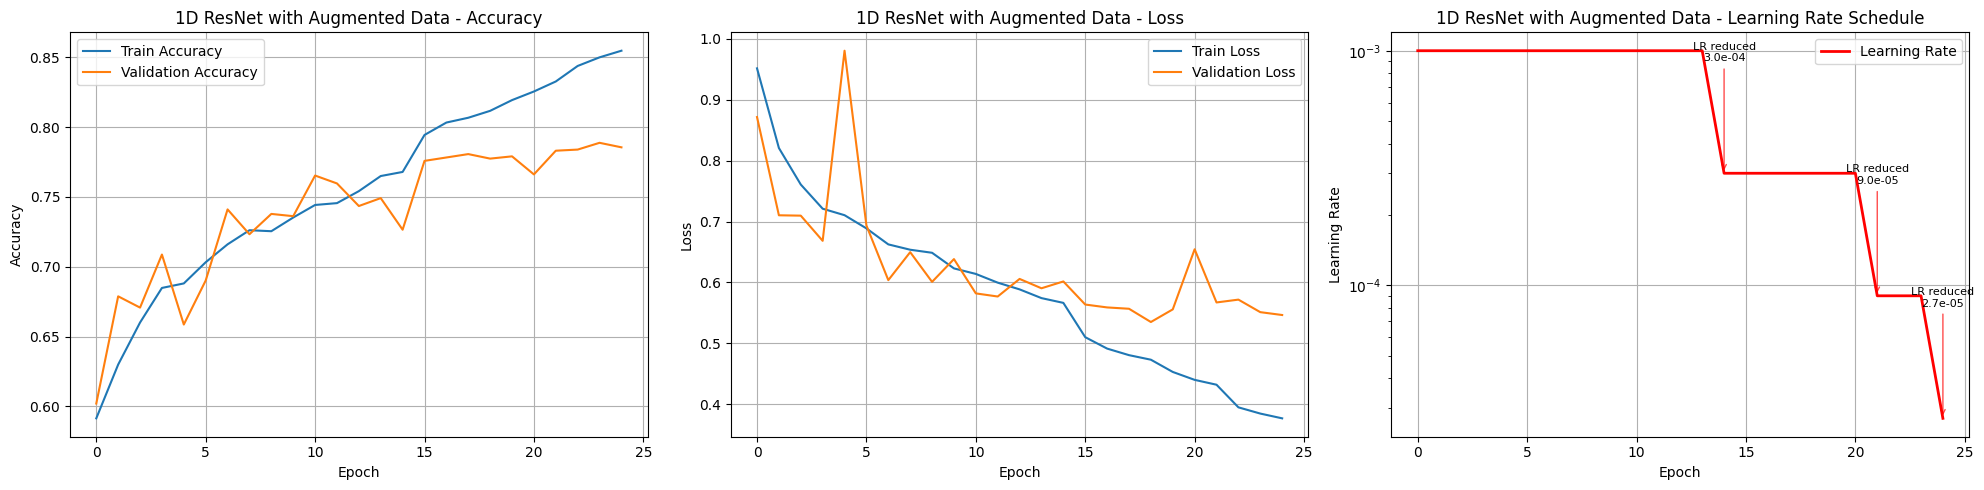

✅ ResNet model training completed!


In [9]:
# Create and compile the ResNet model
print("🏗️ Creating 1D ResNet model...")
resnet_model_aug = create_resnet_model(input_shape, len(metadata['class_names']))
resnet_model_aug, resnet_config = compile_resnet_model(resnet_model_aug)

# Display model architecture
print("\n📋 ResNet Model Architecture:")
resnet_model_aug.summary()

# Train the ResNet model on augmented data
print(f"\n🚀 Training ResNet model with augmented data...")
history_resnet_aug = train_model(
    resnet_model_aug,
    X_train_final,
    y_train_final,
    X_val_final,
    y_val_final,
    resnet_config,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    model_name="1D ResNet (Augmented)"
)

# Plot training history
utils.plot_history_with_lr(history_resnet_aug, "1D ResNet with Augmented Data", resnet_config['lr_tracker'])

print("✅ ResNet model training completed!")

### Model Evaluation and Comparison

COMPREHENSIVE MODEL EVALUATION - AUGMENTED DATA

----------------------------------------
EVALUATING: Baseline STFT-CNN-RNN (Augmented)
----------------------------------------
 Baseline STFT-CNN-RNN (Augmented) - Validation Accuracy: 0.7387
   Parameters: 659,844

Classification Report for Baseline STFT-CNN-RNN (Augmented):
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       728
           1       0.69      0.36      0.48       110
           2       0.60      0.53      0.56       353
           3       0.70      0.51      0.59        45

    accuracy                           0.74      1236
   macro avg       0.70      0.58      0.62      1236
weighted avg       0.73      0.74      0.72      1236



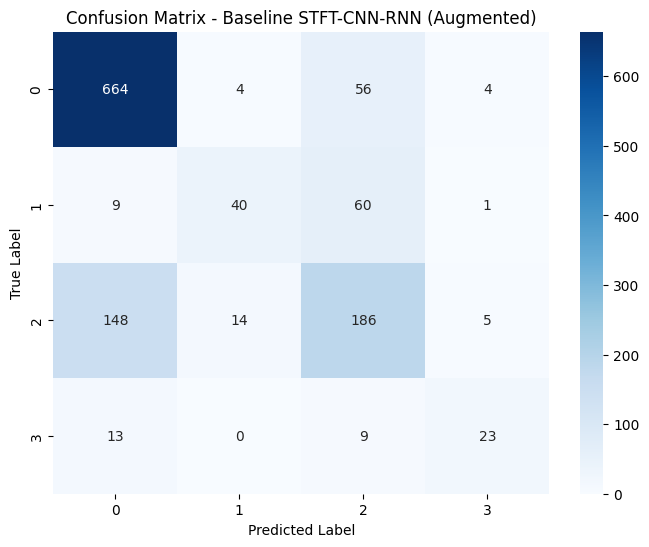


----------------------------------------
EVALUATING: 1D ResNet (Augmented)
----------------------------------------
 1D ResNet (Augmented) - Validation Accuracy: 0.7775
   Parameters: 251,908

Classification Report for 1D ResNet (Augmented):
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       728
           1       0.63      0.91      0.74       110
           2       0.74      0.46      0.57       353
           3       0.89      0.69      0.78        45

    accuracy                           0.78      1236
   macro avg       0.77      0.74      0.74      1236
weighted avg       0.78      0.78      0.76      1236



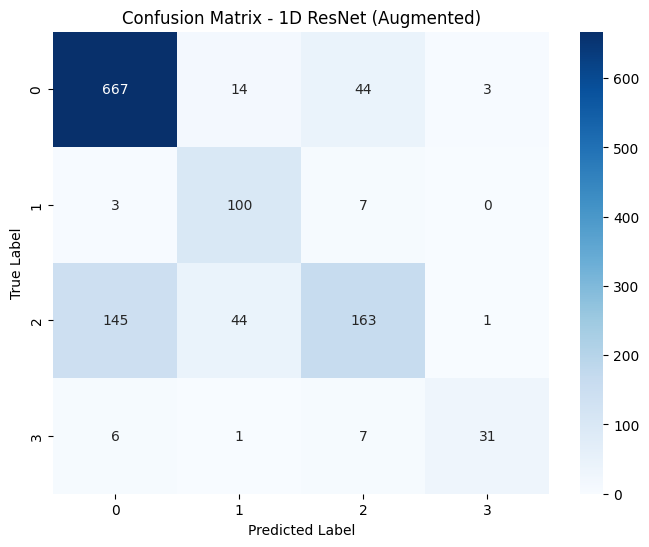


AUGMENTED DATA MODEL COMPARISON
                            Model Accuracy Parameters
Baseline STFT-CNN-RNN (Augmented)   0.7387    659,844
            1D ResNet (Augmented)   0.7775    251,908

🏆 BEST AUGMENTED MODEL: 1D ResNet (Augmented)
   Accuracy: 0.7775
   Parameters: 251,908

✅ Model evaluation completed!


In [10]:
# Evaluate both models trained on augmented data
print("="*60)
print("COMPREHENSIVE MODEL EVALUATION - AUGMENTED DATA")
print("="*60)

# Convert validation labels to numpy array for evaluation
y_val_true = y_val_split.values if hasattr(y_val_split, 'values') else np.array(y_val_split)
class_names = [str(name) for name in metadata['class_names']]

# Evaluate baseline model
baseline_results_aug = evaluate_model(
    'baseline_model.keras', 
    X_val_final, 
    y_val_true, 
    class_names, 
    "Baseline STFT-CNN-RNN (Augmented)",
    custom_objects={'STFTLayer': STFTLayer, 'ReshapeForRNN': ReshapeForRNN}
)

# Evaluate ResNet model
resnet_results_aug = evaluate_model(
    'resnet_model.keras', 
    X_val_final, 
    y_val_true, 
    class_names, 
    "1D ResNet (Augmented)"
)

# Model comparison
print("\n" + "="*60)
print("AUGMENTED DATA MODEL COMPARISON")
print("="*60)

models_aug = {
    "Baseline STFT-CNN-RNN (Augmented)": baseline_results_aug,
    "1D ResNet (Augmented)": resnet_results_aug
}

# Create comparison table
comparison_data_aug = []
for model_name, results in models_aug.items():
    if results:
        comparison_data_aug.append({
            "Model": model_name,
            "Accuracy": f"{results['accuracy']:.4f}",
            "Parameters": f"{results['parameters']:,}",
        })

if comparison_data_aug:
    comparison_df_aug = pd.DataFrame(comparison_data_aug)
    print(comparison_df_aug.to_string(index=False))
    
    # Find best model
    best_model_aug = max(models_aug.keys(), 
                        key=lambda x: models_aug[x]['accuracy'] if models_aug[x] else 0)
    best_accuracy_aug = models_aug[best_model_aug]['accuracy']
    
    print(f"\n🏆 BEST AUGMENTED MODEL: {best_model_aug}")
    print(f"   Accuracy: {best_accuracy_aug:.4f}")
    print(f"   Parameters: {models_aug[best_model_aug]['parameters']:,}")

print("\n✅ Model evaluation completed!")

### Generate Test Predictions with Best Augmented Model

In [11]:
# Generate test predictions using the best augmented model
print("="*60)
print("GENERATING TEST PREDICTIONS WITH AUGMENTED MODEL")
print("="*60)

# Determine best model and its custom objects
if baseline_results_aug and resnet_results_aug:
    if baseline_results_aug['accuracy'] > resnet_results_aug['accuracy']:
        best_model_path = 'baseline_model.keras'
        best_model_name = 'Baseline STFT-CNN-RNN (Augmented)'
        custom_objects = {'STFTLayer': STFTLayer, 'ReshapeForRNN': ReshapeForRNN}
    else:
        best_model_path = 'resnet_model.keras'
        best_model_name = '1D ResNet (Augmented)'
        custom_objects = None
elif baseline_results_aug:
    best_model_path = 'baseline_model.keras'
    best_model_name = 'Baseline STFT-CNN-RNN (Augmented)'
    custom_objects = {'STFTLayer': STFTLayer, 'ReshapeForRNN': ReshapeForRNN}
elif resnet_results_aug:
    best_model_path = 'resnet_model.keras'
    best_model_name = '1D ResNet (Augmented)'
    custom_objects = None
else:
    print("❌ No valid models found!")
    best_model_path = None

if best_model_path:
    print(f"🏆 Using {best_model_name} for test predictions")
    
    # Load test data
    X_test = utils.read_binary_file("../dataset/X_test.bin")
    
    # Generate predictions
    test_predictions = generate_test_predictions(
        best_model_path, 
        X_test, 
        metadata, 
        custom_objects=custom_objects,
        output_file='augment.csv'
    )
    
    print(f"\n✅ Test predictions generated successfully!")
    print(f"📁 Predictions saved to 'augment.csv'")
    print(f"🎯 Used model: {best_model_name}")
    
    # Display first few predictions
    augment_df = pd.read_csv('augment.csv')
    print(f"\nFirst 10 predictions:")
    print(augment_df.head(10))

print("\n" + "="*60)

GENERATING TEST PREDICTIONS WITH AUGMENTED MODEL
🏆 Using 1D ResNet (Augmented) for test predictions
Loading and preprocessing test data...
Test data preprocessed. Shape: (2649, 8000, 1)
Loading model and generating predictions...
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
Predictions generated for 2649 test samples
Creating submission file...
Predictions saved to 'augment.csv'

📈 PREDICTION STATISTICS:
Total predictions: 2649
Class distribution:
  Class 0 (Normal): 1720 samples (64.9%)
  Class 1 (AF): 343 samples (12.9%)
  Class 2 (Other): 506 samples (19.1%)
  Class 3 (Noisy): 80 samples (3.0%)

✅ Test predictions generated successfully!
📁 Predictions saved to 'augment.csv'
🎯 Used model: 1D ResNet (Augmented)

First 10 predictions:
   id  class
0   0      0
1   1      0
2   2      0
3   3      0
4   4      0
5   5      2
6   6      0
7   7      0
8   8      0
9   9      0

